This notebook explores the Medical Cost Personal Dataset through the lenses of both Regression and Classification. The goal is to build a robust system that can not only predict the specific dollar amount of medical insurance charges but also categorize individuals into "cost brackets" with high confidence.

### Content

* #### I. [Data Preparation](#prep)
* #### II. [Probabilistic Regression](#regression)
* #### III. [Ensemble Methods](#ensemble)
* #### IV. [Discretization Strategy](#discrete)
* #### V. [Probability & Overfitting](#probs)
* #### VI. [GridSearchCV Optimization](#opt) | 
* #### VII. [Metric Bridging](#metrics)

<a id="prep"></a>
### Data Preparation & Preprocessing

First of all, let's import all necessary libraies:

In [338]:
import numpy as np
import pandas as pd

from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.model_selection import train_test_split, cross_validate, GridSearchCV
from sklearn.compose import ColumnTransformer
from sklearn.metrics import mean_absolute_error, root_mean_squared_error, r2_score
from sklearn.linear_model import LinearRegression, ElasticNet, Ridge, Lasso
from sklearn.tree import DecisionTreeRegressor

import matplotlib.pyplot as plt
import seaborn as sns

Let's load dataset ans see some stats:

In [339]:
data = pd.read_csv("./data/insurance.csv")

data.head()

,age,sex,bmi,children,smoker,region,charges
0,19,female,27.900,0,yes,southwest,16884.92400
1,18,male,33.770,1,no,southeast,1725.55230
2,28,male,33.000,3,no,southeast,4449.46200
3,33,male,22.705,0,no,northwest,21984.47061
4,32,male,28.880,0,no,northwest,3866.85520


In [340]:
data.shape

(1338, 7)

In [341]:
data.columns

Index(['age', 'sex', 'bmi', 'children', 'smoker', 'region', 'charges'], dtype='object')

In [342]:
data.dtypes

age           int64
sex          object
bmi         float64
children      int64
smoker       object
region       object
charges     float64
dtype: object

In [343]:
data.isna().sum()

age         0
sex         0
bmi         0
children    0
smoker      0
region      0
charges     0
dtype: int64

Data seems to be clean. Let's split data into train and test, and transform it:

In [344]:
X = data.drop(columns="charges")
y = data["charges"]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

X_train.shape, X_test.shape

((1070, 6), (268, 6))

In [345]:
cat_idx = X_train.select_dtypes(include="object").columns
num_idx = X_train.select_dtypes(exclude="object").columns

cat_idx, num_idx

(Index(['sex', 'smoker', 'region'], dtype='object'),
 Index(['age', 'bmi', 'children'], dtype='object'))

In [346]:
[X_train[idx].value_counts() for idx in cat_idx]

[sex
 male      548
 female    522
 Name: count, dtype: int64,
 smoker
 no     850
 yes    220
 Name: count, dtype: int64,
 region
 southeast    283
 northeast    267
 southwest    264
 northwest    256
 Name: count, dtype: int64]

In [347]:
preprocessor = ColumnTransformer(transformers=[
    ("num", StandardScaler(), num_idx.tolist()),
    ("cat", OneHotEncoder(drop="first", sparse_output=False), cat_idx.tolist())
])

preprocessor.set_output(transform="pandas")

X_train_transformed = preprocessor.fit_transform(X_train)
X_test_transformed = preprocessor.transform(X_test)

Here is an important moment: we need to fit out preprocessor with train data, not test, in order to prevent data leakage.

In [348]:
X_train_transformed.head()

,num__age,num__bmi,num__children,cat__sex_male,cat__smoker_yes,cat__region_northwest,cat__region_southeast,cat__region_southwest
560,0.472227,-1.756525,0.734336,0.0,0.0,1.0,0.0,0.0
1285,0.543313,-1.033082,-0.911192,0.0,0.0,0.0,0.0,0.0
1142,0.898745,-0.943687,-0.911192,0.0,0.0,0.0,1.0,0.0
969,-0.025379,0.622393,3.202629,0.0,0.0,0.0,1.0,0.0
486,1.040918,-1.504893,1.557100,0.0,0.0,1.0,0.0,0.0


In [349]:
X_train_transformed.shape

(1070, 8)

And now, we are ready to go forward

<a id="regression"></a>
### Probabilistic Regression

For now, let's train some models(not ensemble) in the following list:

In [350]:
models = [
    ("Lin.Regr", LinearRegression()),
    ("Lasso", Lasso()),
    ("Ridge", Ridge()),
    ("ElasticNet", ElasticNet()),
    ("Des. Tree Reg.", DecisionTreeRegressor(random_state=42)) 
]

In [351]:
scoring = {
    'MAE': 'neg_mean_absolute_error',
    'R2': 'r2',
    'RMSE': 'neg_root_mean_squared_error'
}

results = []
k = 5

for name, model in models:
    cv_results = cross_validate(
        estimator=model,
        X=X_train_transformed,
        y=y_train,
        cv=k,
        scoring=scoring
    )

    results.append({
        "Model": name,
        "MAE": -cv_results['test_MAE'].mean(),
        "RMSE": -cv_results['test_RMSE'].mean(),
        "R2": cv_results['test_R2'].mean()
    })

results_df = pd.DataFrame(results).sort_values(by="MAE")

In [352]:
def plot_regression_metrics(df, title, mae_palette='viridis_r', r2_palette='magma'):
    sns.set_theme(style="whitegrid")
    
    fig, axes = plt.subplots(1, 2, figsize=(15, 6))
    
    sns.barplot(
        data=df.sort_values(by="MAE"), 
        x='MAE', 
        y='Model', 
        hue='Model',       
        legend=False,      
        palette=mae_palette, 
        ax=axes[0]
    )
    axes[0].set_title('Mean Absolute Error', fontsize=12, fontweight='bold', pad=10)
    axes[0].set_xlabel('MAE', fontsize=11)
    axes[0].set_ylabel('Model', fontsize=11)

    sns.barplot(
        data=df.sort_values(by="R2", ascending=False), 
        x='R2', 
        y='Model', 
        hue='Model',       
        legend=False,     
        palette=r2_palette, 
        ax=axes[1]
    )
    axes[1].set_title('R² Score', fontsize=12, fontweight='bold', pad=10)
    axes[1].set_xlabel('R² Score', fontsize=11)
    axes[1].set_ylabel('') 

    fig.suptitle(title, fontsize=18, fontweight='bold', y=1.02)
    
    plt.tight_layout()
    plt.show()

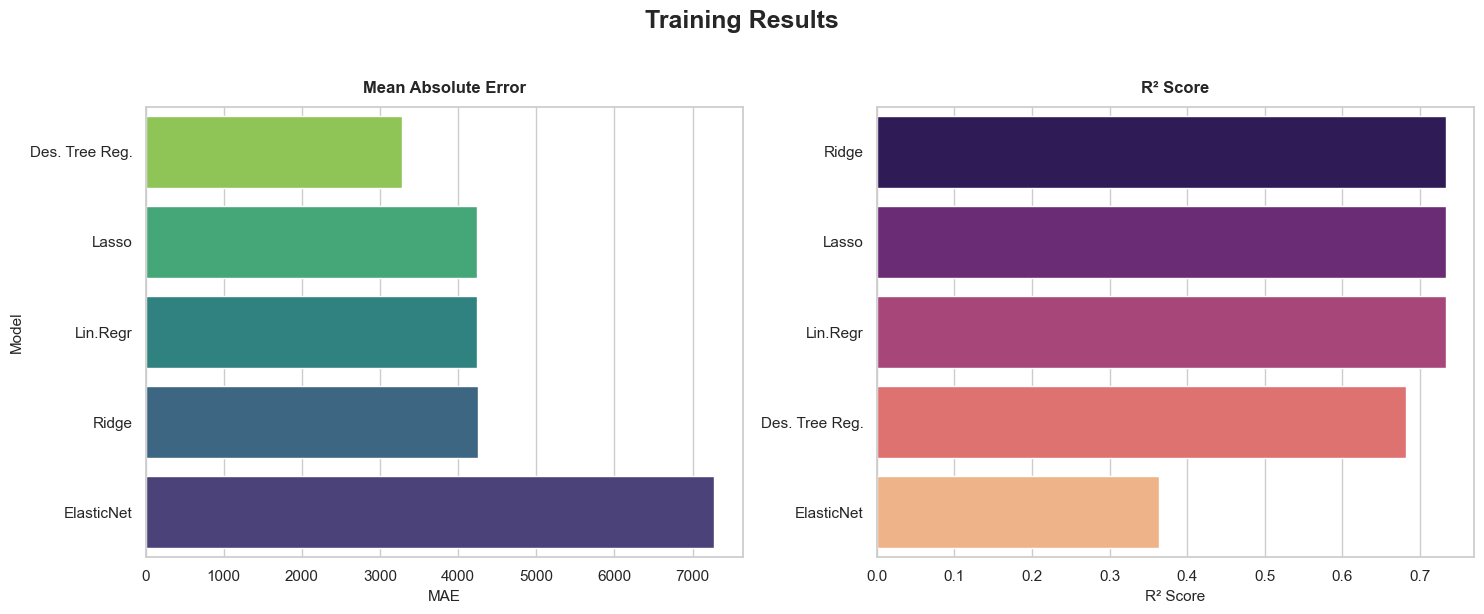

In [353]:
plot_regression_metrics(results_df, title="Training Results")

Above we see results of training

Next, i want to compute confidence intervals for model's predictions. In a standard linear model, we assume the relationship is:
$$y = f(x) + \epsilon$$
Where $\epsilon$ is the "noise" or error. To make this probabilistic, we assume this noise follows a Normal distribution with a mean of zero:
$$\epsilon \sim \mathcal{N}(0, \sigma^2)$$
This means that for any prediction $\hat{y}$, the "true" value $y$ is actually a distribution centered at $\hat{y}$ with a spread defined by $\sigma$.
Since I have already performed Cross-Validation on training set, I have the most robust estimate of $\sigma$. The RMSE (Root Mean Squared Error) is mathematically the best estimate of the standard deviation of the residuals for unseen data.
$$\sigma \approx \text{RMSE}_{CV}$$
I want a 95% Confidence Interval. In a standard Normal distribution ($Z$-distribution):95% of the data falls within approximately 1.96 standard deviations of the mean.This $1.96$ is the Z-score ($Z_{\alpha/2}$) for a 95% two-tailed test.
For every individual prediction $\hat{y}_i$ in test set, I will calculate the upper and lower limits:
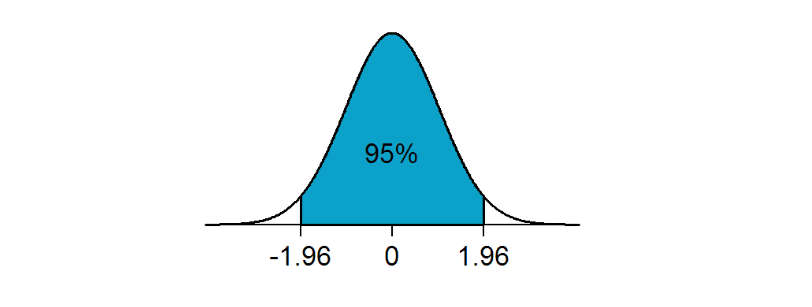
$$Upper\ Bound = \hat{y}_i + (1.96 \cdot \text{RMSE}_{CV})$$
$$Lower\ Bound = \hat{y}_i - (1.96 \cdot \text{RMSE}_{CV})$$

In [354]:
def get_conf_int(y_hat, se, z=1.96):
    return (y_hat + z * se, y_hat - z * se)

In [355]:
trained_models = []

for name, model in models:
    trained_models.append((
        name, model.fit(X_train_transformed, y_train)
    ))

In [356]:
all_predictions = []
results = []

for name, model in trained_models:
    y_hat = model.predict(X_test_transformed)
    
    se = results_df[results_df["Model"] == name]["RMSE"].values[0]
    
    ci_plus, ci_minus = get_conf_int(y_hat, se)
    
    df_temp = pd.DataFrame({
        'Actual': y_test.values,
        'Predicted': y_hat,
        'Lower_Bound': np.maximum(0, ci_minus), 
        'Upper_Bound': ci_plus,
        'Model': name,
    })
    all_predictions.append(df_temp)

    results.append({
        "Model": name,
        "RMSE": root_mean_squared_error(y_test, y_hat),
        "R2": r2_score(y_test, y_hat),
        "MAE": mean_absolute_error(y_test, y_hat),
    })

results_df = pd.DataFrame(results).sort_values(by="MAE")
final_preds_df = pd.concat(all_predictions, ignore_index=True)

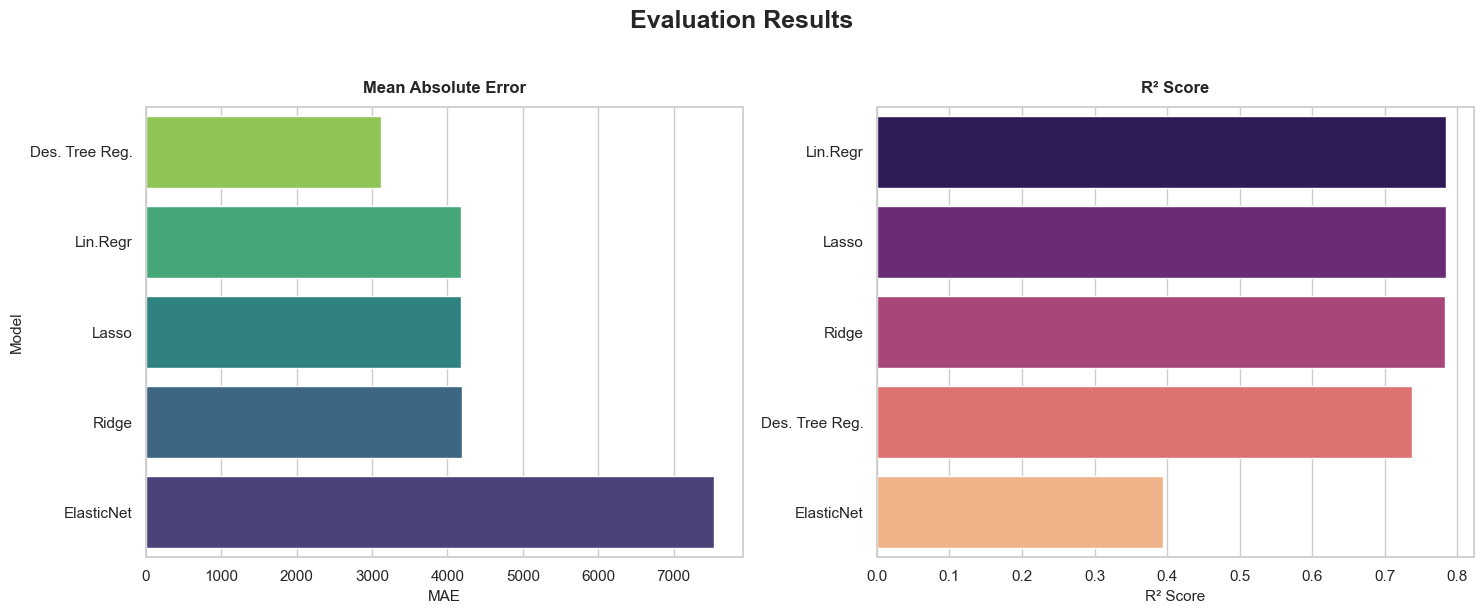

In [357]:
plot_regression_metrics(results_df, title="Evaluation Results")

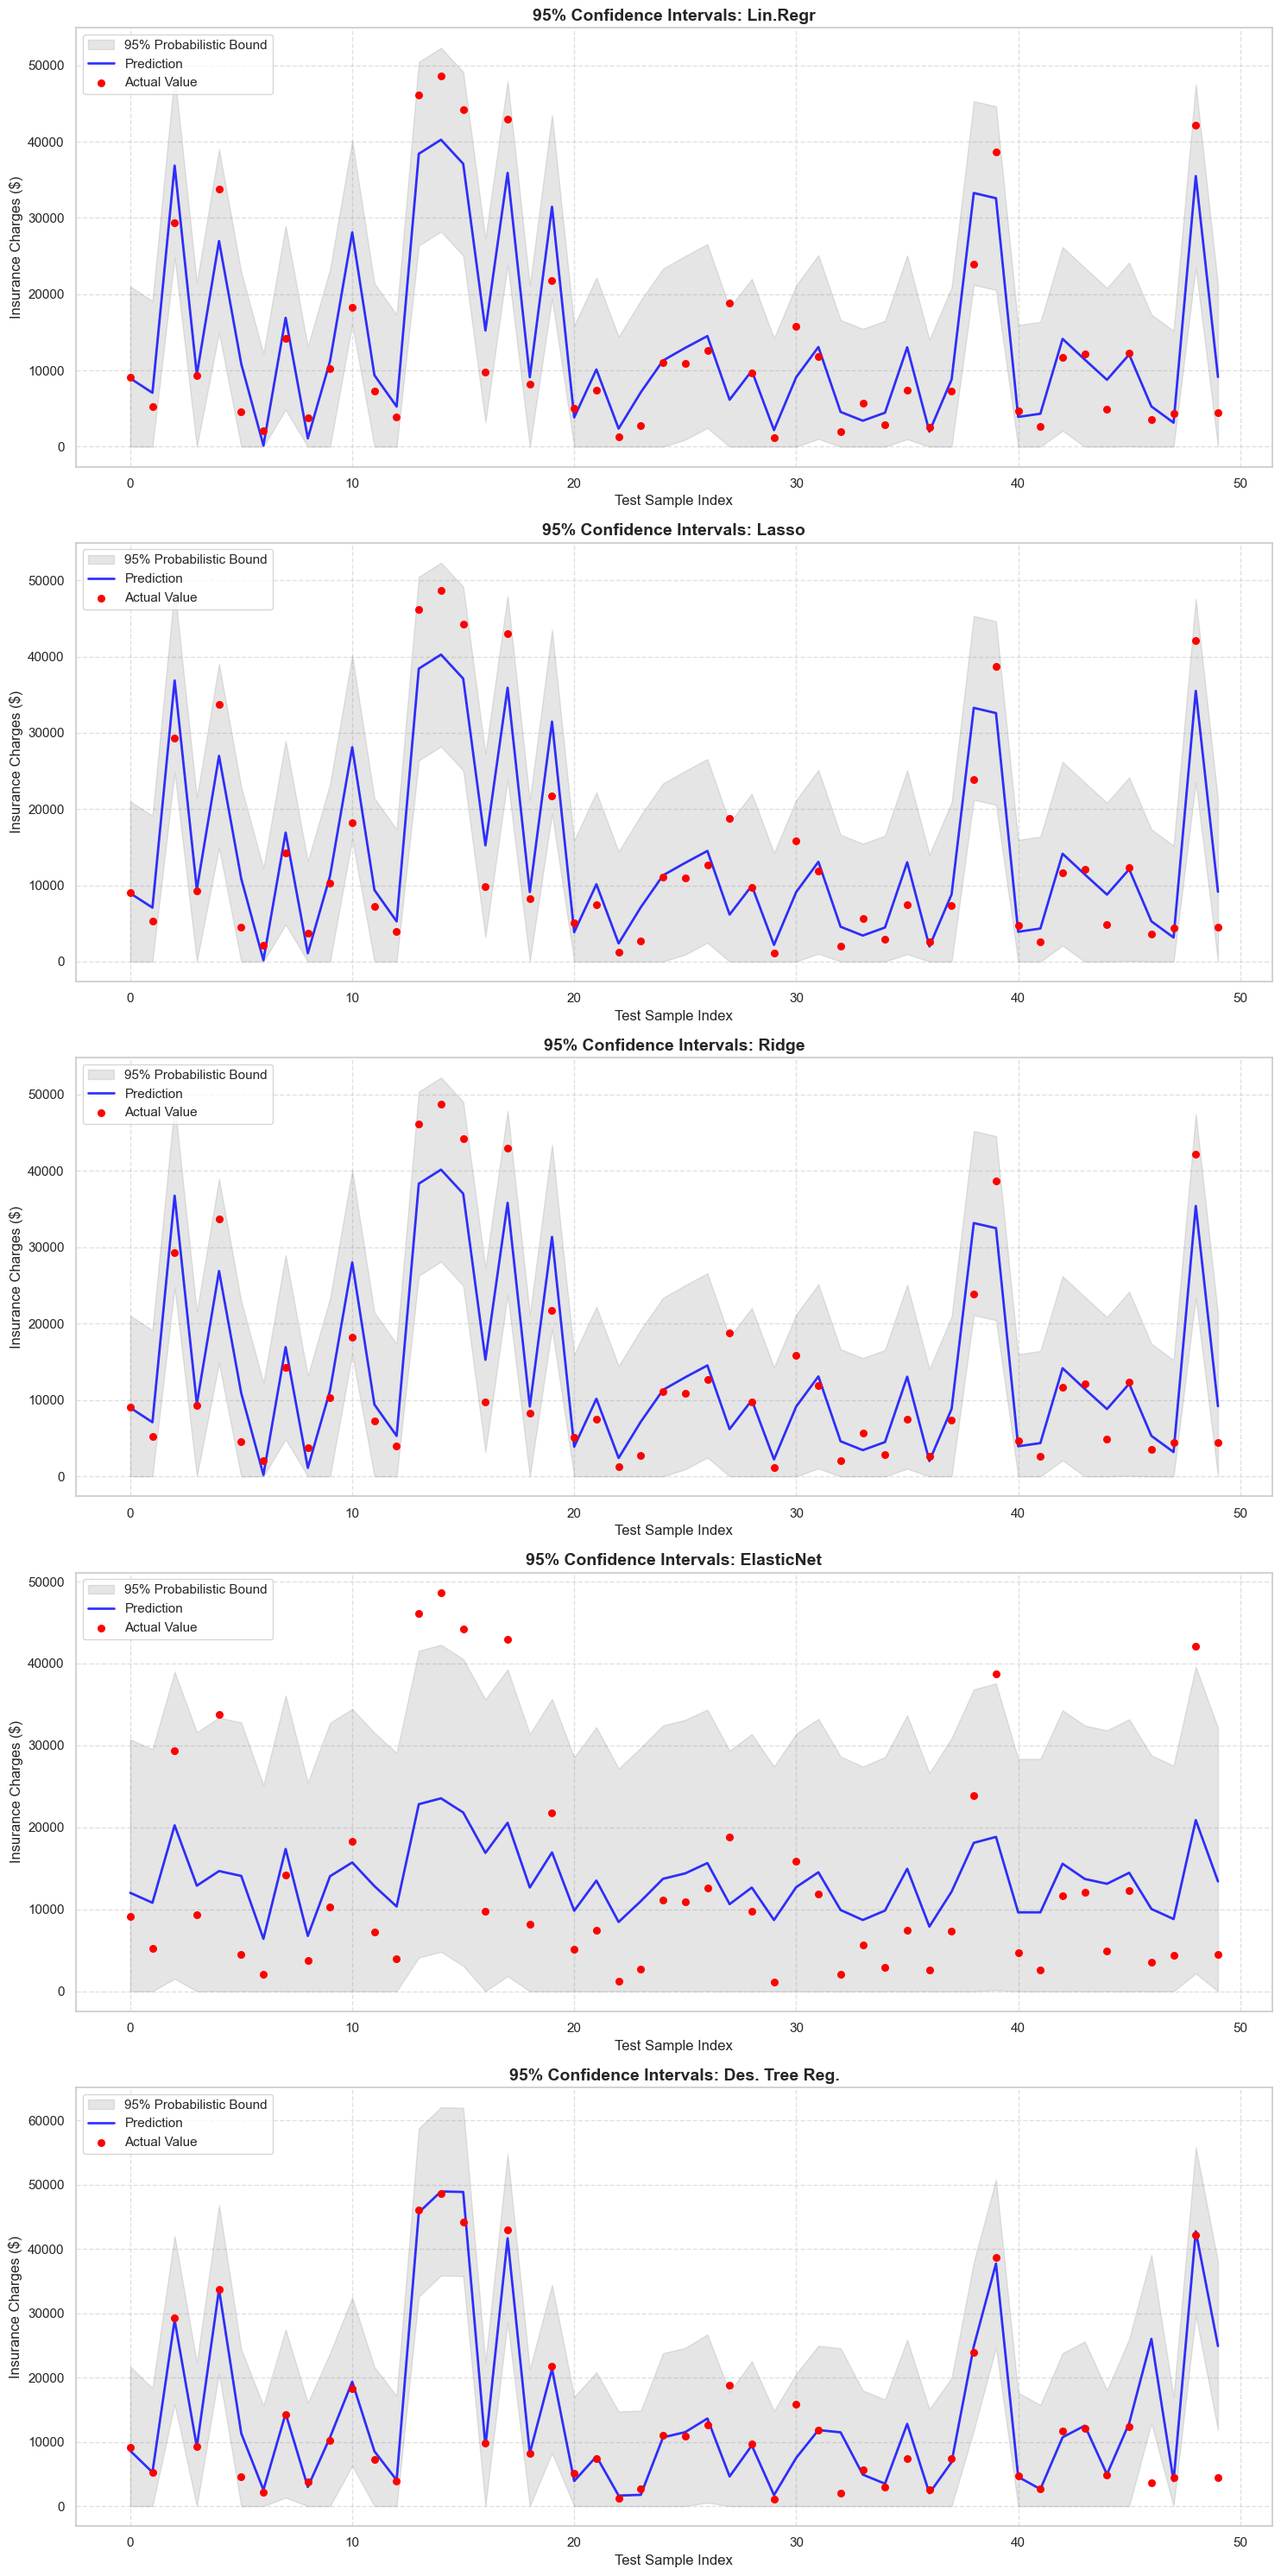

In [358]:
def plot_model_intervals(df, models_list, n_samples=50):
    n_models = len(models_list)
    fig, axes = plt.subplots(n_models, 1, figsize=(15, 6 * n_models))
    
    if n_models == 1:
        axes = [axes]

    for i, model_name in enumerate(models_list):
        sample_df = df[df["Model"] == model_name].iloc[:n_samples].reset_index(drop=True)
        ax = axes[i]
        
        ax.fill_between(sample_df.index, 
                        sample_df['Lower_Bound'], 
                        sample_df['Upper_Bound'], 
                        color='gray', alpha=0.2, label='95% Probabilistic Bound')

        ax.plot(sample_df.index, sample_df['Predicted'], 
                label='Prediction', color='blue', linewidth=2, alpha=0.8)

        ax.scatter(sample_df.index, sample_df['Actual'], 
                   label='Actual Value', color='red', s=30, zorder=3)

        ax.set_title(f'95% Confidence Intervals: {model_name}', fontsize=14, fontweight='bold')
        ax.set_xlabel('Test Sample Index')
        ax.set_ylabel('Insurance Charges ($)')
        ax.legend(loc='upper left')
        ax.grid(True, linestyle='--', alpha=0.6)

    plt.tight_layout()
    plt.show()

unique_models = final_preds_df["Model"].unique()

plot_model_intervals(final_preds_df, unique_models, n_samples=50)

From the image above we see some interesinting stuff: ElasticNet has wide confidence interval and low accuracy of prediction, while Desicion Regressor Tree has narrow confidence interval and almost all values are predicted correctly.

Let's pick Desicion Tree Regressor and tune it, and see how the results will change:

In [359]:
# save it now to be able to compare with tuned model
final_preds_df =  final_preds_df[final_preds_df["Model"] == "Des. Tree Reg."]
results_df = results_df[results_df["Model"] == "Des. Tree Reg."]

In [360]:
param_grid = {
    "max_depth": [3, 5, 10, None],
    "min_samples_split": [2, 10, 20],
    "min_samples_leaf": [1, 5, 10],
    "criterion": ["squared_error", "friedman_mse"],
    "max_features": ["sqrt", None]
}
scoring = {
    'MAE': 'neg_mean_absolute_error',
    'R2': 'r2',
    'RMSE': 'neg_root_mean_squared_error'
}
k = 5
tree = models[-1][1]

grid = GridSearchCV(
    estimator=tree,
    param_grid=param_grid,
    scoring=scoring,
    refit='R2', 
    n_jobs=-1,  
    verbose=1
)

grid.fit(X_train_transformed, y_train)


Fitting 5 folds for each of 144 candidates, totalling 720 fits


,estimator,DecisionTreeR...ndom_state=42)
,param_grid,"{'criterion': ['squared_error', 'friedman_mse'], 'max_depth': [3, 5, ...], 'max_features': ['sqrt', None], 'min_samples_leaf': [1, 5, ...], ...}"
,scoring,"{'MAE': 'neg_mean_absolute_error', 'R2': 'r2', 'RMSE': 'neg_root_mean_squared_error'}"
,n_jobs,-1
,refit,'R2'
,cv,None
,verbose,1
,pre_dispatch,'2*n_jobs'
,error_score,nan
,return_train_score,False
,criterion,'squared_error'


In [361]:
print(f"Best R2: {grid.best_score_}")
print(f"Best Params: {grid.best_params_}")

Best R2: 0.8356879686154602
Best Params: {'criterion': 'squared_error', 'max_depth': 3, 'max_features': None, 'min_samples_leaf': 1, 'min_samples_split': 2}


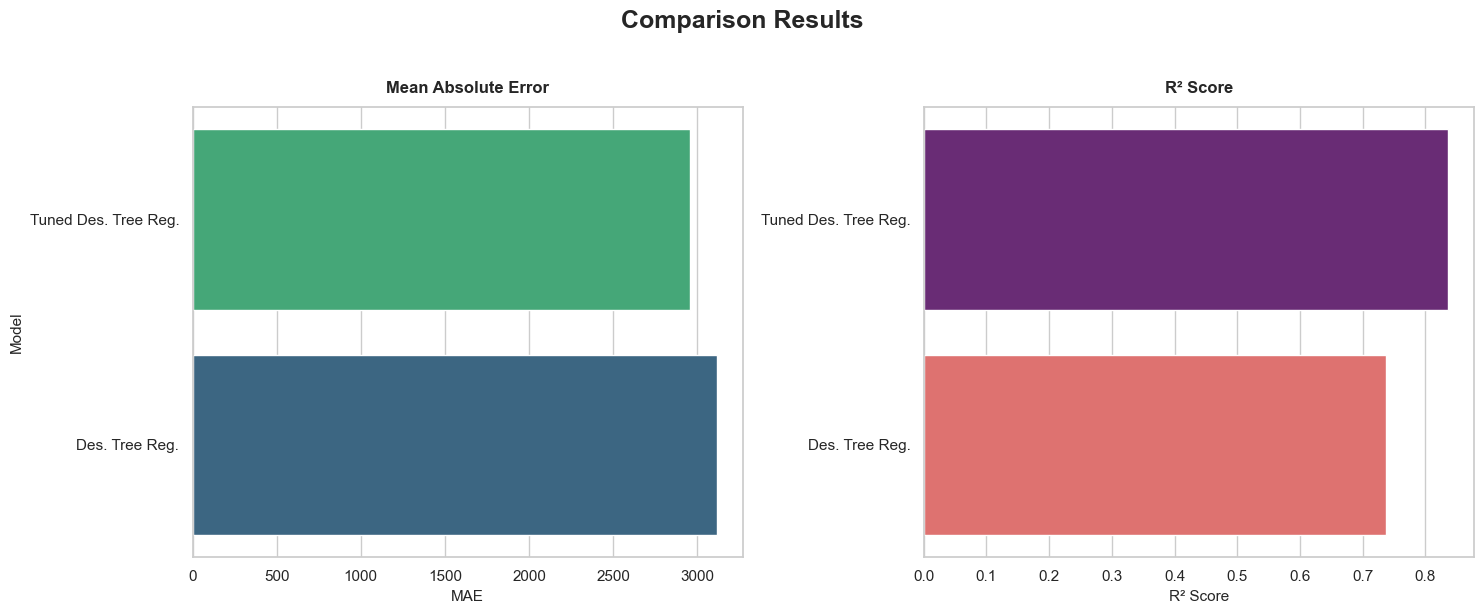

In [362]:
results = []

tuned_tree = grid.best_estimator_

y_hat = tuned_tree.predict(X_test_transformed)

results.append({
    "Model": "Tuned Des. Tree Reg.",
    "RMSE": abs(grid.cv_results_["mean_test_RMSE"][grid.best_index_]),
    "R2": grid.cv_results_["mean_test_R2"][grid.best_index_],
    "MAE": abs(grid.cv_results_["mean_test_MAE"][grid.best_index_]),
})

tuned_results_df = pd.DataFrame(results).sort_values(by="MAE")
final_results_df = pd.concat([tuned_results_df, results_df])

plot_regression_metrics(final_results_df, title="Comparison Results")

Since in hyperparameter tuning we was aimed to minimize R2 - we see the corresponding results, MAE is also decreased

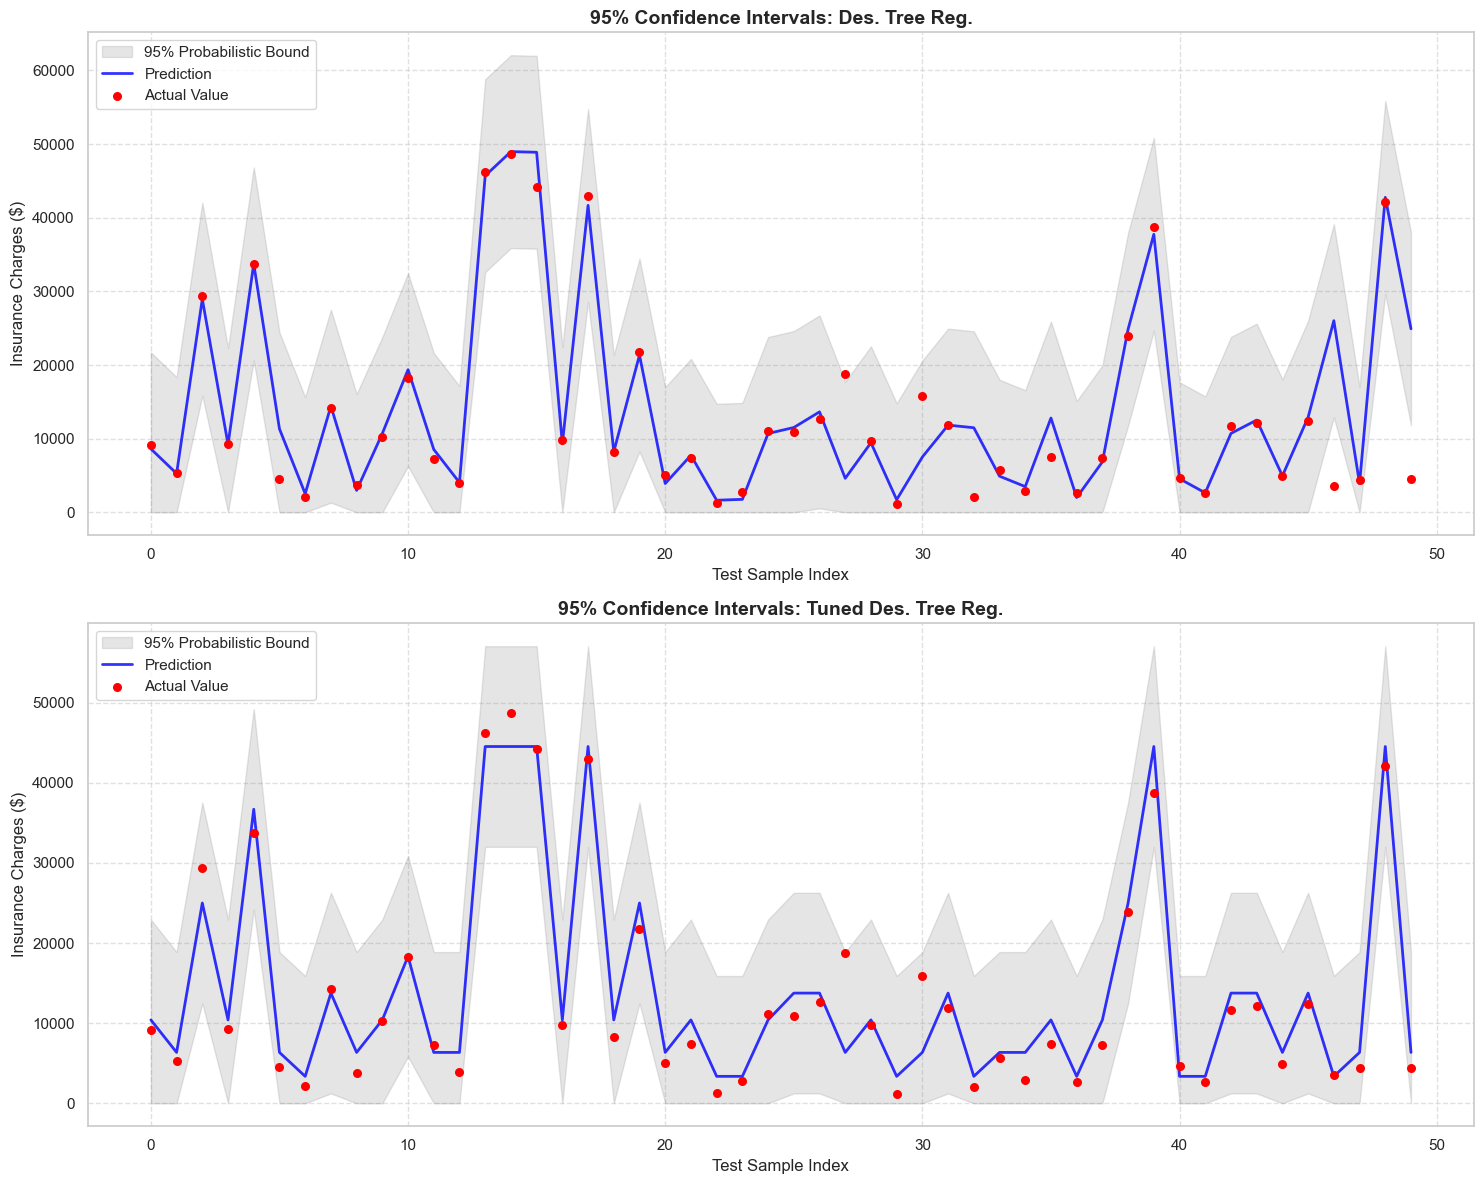

In [363]:
ci_plus, ci_minus = get_conf_int(y_hat, results_df["RMSE"].values[0])

tuned_final_preds_df = pd.concat([
    pd.DataFrame({
        'Actual': y_test.values,
        'Predicted': y_hat,
        'Lower_Bound': np.maximum(0, ci_minus), 
        'Upper_Bound': ci_plus,
        'Model': "Tuned Des. Tree Reg.",
    })
], ignore_index=True)

compare_preds_df = pd.concat([final_preds_df, tuned_final_preds_df])

unique_models = compare_preds_df["Model"].unique()
plot_model_intervals(compare_preds_df, unique_models, n_samples=50)

We see, that tuned model looks less overfitted and is aimed for generalization, not memorizing as untuned. This it the consequence of constraining params with grid search.

<a id="ensemble"></a>
### Ensemble Methods

<a id="discrete"></a>
### Discretization (Regression to Classification)

<a id="probs"></a>
### Probability Distributions & Confidence

<a id="opt"></a>
### Optimization via GridSearchCV

<a id="metrics"></a>
### Metric Bridging & Final Conversion